#Libraries

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import xgboost as xgb
from collections import Counter
import numpy as np
import itertools
from pathlib import Path
import pandas as pd
from collections import Counter
from itertools import product
import numpy as np, pandas as pd, re
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data-Sets

In [19]:
def load_fasta_file(path: Path):
    seqs, labs = [], []
    lines = path.read_text().splitlines()
    for i in range(0, len(lines), 2):
        header = lines[i].strip()
        if not header:
            continue
        seq  = lines[i+1].strip() if i+1 < len(lines) else ""
        labs.append(1 if "Positive" in header or ">1" in header or "positive" in header or "POSITIVE" in header else 0)
        seqs.append(seq.upper())
    return seqs, labs

def load_fasta_data(data_dir, files):
    seqs, labs, per_file_counts = [], [], {}
    for fname in files:
        seq, lab = load_fasta_file(Path(data_dir) / fname)
        seqs.extend(seq)
        labs.extend(lab)
        per_file_counts[fname] = Counter(lab)

    lengths = [len(s) for s in seqs]
    min_len = min(lengths)
    max_len = max(lengths)

    df = pd.DataFrame({"seq": seqs, "label": labs})

    print(f"Shortest sequence length in original dataset : {min_len}")
    print(f"Longest  sequence length in original dataset : {max_len}")

    print(f"\nTotal sequences : {len(df):,}")
    print(f"Class balance   : {Counter(df.label)}")

    print("\nBreak-down per file:")
    for f, c in per_file_counts.items():
        print(f"  {f:<12}  Pos={c[1]:>4}  Neg={c[0]:>4}")

    print("\nDataFrame preview:")
    display(df.sample(5))
    print("\n\n")
    return df

# Load data for each species using the new function
data_dir_fruit_fly = "/kaggle/input/tri-ori/Tri-Ori/training"
files_fruit_fly = ["bmark-BG3_F_F.txt", "bmark-KC_F_F.txt", "bmark-S2_F_F.txt"]
df_fruit_fly = load_fasta_data(data_dir_fruit_fly, files_fruit_fly)

data_dir_human = "/kaggle/input/tri-ori/Tri-Ori/training"
files_human = ["bmark-K562_Human.txt", "bmark-MCF7_Human.txt"]
df_human = load_fasta_data(data_dir_human, files_human)

data_dir_mouse = "/kaggle/input/tri-ori/Tri-Ori/training"
files_mouse = ["bmark-ES_Mouse.txt", "bmark-P19_Mouse.txt", "bmark-MEF_Mouse.txt"]
df_mouse = load_fasta_data(data_dir_mouse, files_mouse)

Shortest sequence length in original dataset : 300
Longest  sequence length in original dataset : 300

Total sequences : 18,250
Class balance   : Counter({1: 9135, 0: 9115})

Break-down per file:
  bmark-BG3_F_F.txt  Pos=2763  Neg=2764
  bmark-KC_F_F.txt  Pos=3022  Neg=3000
  bmark-S2_F_F.txt  Pos=3350  Neg=3351

DataFrame preview:


,seq,label
12622,TTTTCAAACAGGTCCCCATGTCCTGTGTCCTGTGTCCCATGTCCTC...,1
11272,TTACTCTCCCTTTTGTGCGTTGTTCGCAGTGCTGTTTGGTGTTGTT...,0
2313,TGCAACAAGTGGCAGGTTTCTAACGATCCCGAGAGTCCACCCCTTT...,1
2723,CCTAAATATTTGATCTGAACTATGCCAACCTGGTTTCGTTTCTGAG...,1
9250,GCGCGTAGAGTAAAAGGGTATACTATACTATACTATAAAGTATGTA...,0





Shortest sequence length in original dataset : 300
Longest  sequence length in original dataset : 300

Total sequences : 6,189
Class balance   : Counter({1: 3095, 0: 3094})

Break-down per file:
  bmark-K562_Human.txt  Pos=1332  Neg=1331
  bmark-MCF7_Human.txt  Pos=1763  Neg=1763

DataFrame preview:


,seq,label
2259,CACGGGCCTCCCGCCTGTCCTGGCGCCGCCGTCGCATGGCCAGAAC...,0
5466,TCCAGCTGGTTGGCGCTCAGGTCCAGCAGCTGCAGCGCGCCCAGGC...,0
2378,TGGAGAGATGCCTTTAACAGAGGGAGTTGGAAGCAACCTGCTTTCA...,0
5361,GGCCCCTGAGACCGTGGCTCCCGCTGTGATGTGGCGTGTTGGGGAG...,0
3519,GTGTAGGACCTGGCCCAGGGCCTGGCTCCAGGAGGTTCTCAAATCC...,1





Shortest sequence length in original dataset : 300
Longest  sequence length in original dataset : 300

Total sequences : 8,614
Class balance   : Counter({1: 4307, 0: 4307})

Break-down per file:
  bmark-ES_Mouse.txt  Pos=1380  Neg=1380
  bmark-P19_Mouse.txt  Pos=1725  Neg=1725
  bmark-MEF_Mouse.txt  Pos=1202  Neg=1202

DataFrame preview:


,seq,label
3958,GGGTAGAAACCACTGTTGGGATGCTGGGTTGGGAGGGAGGGGGCAG...,1
3999,GCCACCACCCTCTCAGGAGGCTCAGAGACAGGATGAGGGTCTGGTG...,1
1596,CATTCCTGTGTCTCACTTTTCCTTTATTTTGCTTCTAGCTTGGGTT...,0
7766,ACCTGCCTCTGCCTCCCAAGTGCTGGGATTAAAGGCGTGTGCCACC...,0
2611,ATTTAATTTGTTAATGGCCTGCCAGTGCAGAGGCTCGTATTCTCTC...,0


## K-mer Counts

In [20]:
def count_kmers(sequence, k):
    kmer_counts = Counter()
    num_kmers = len(sequence) - k + 1
    for i in range(num_kmers):
        kmer = sequence[i:i+k]
        kmer_counts[kmer] += 1
    return kmer_counts

k_size = 5

df_fruit_fly_kmer = pd.DataFrame({
    'label': df_fruit_fly['label'],
    'kmer_counts': df_fruit_fly['seq'].apply(lambda seq: count_kmers(seq, k_size))
})

df_human_kmer = pd.DataFrame({
    'label': df_human['label'],
    'kmer_counts': df_human['seq'].apply(lambda seq: count_kmers(seq, k_size))
})

df_mouse_kmer = pd.DataFrame({
    'label': df_mouse['label'],
    'kmer_counts': df_mouse['seq'].apply(lambda seq: count_kmers(seq, k_size))
})


print(f"Fruit Fly DataFrame with {k_size}-mer counts:")
display(df_fruit_fly_kmer.head(2))

print(f"\nHuman DataFrame with {k_size}-mer counts:")
display(df_human_kmer.head(2))

print(f"\nMouse DataFrame with {k_size}-mer counts:")
display(df_mouse_kmer.head(2))

Fruit Fly DataFrame with 5-mer counts:


,label,kmer_counts
0,1,"{'GATAT': 2, 'ATATT': 6, 'TATTT': 3, 'ATTTA': ..."
1,1,"{'GATGA': 1, 'ATGAC': 1, 'TGACT': 1, 'GACTC': ..."



Human DataFrame with 5-mer counts:


,label,kmer_counts
0,1,"{'TGGAG': 3, 'GGAGG': 8, 'GAGGT': 2, 'AGGTA': ..."
1,1,"{'CAGCC': 3, 'AGCCC': 3, 'GCCCA': 3, 'CCCAG': ..."



Mouse DataFrame with 5-mer counts:


,label,kmer_counts
0,1,"{'CCCCT': 2, 'CCCTA': 1, 'CCTAA': 1, 'CTAAC': ..."
1,1,"{'GGGCA': 1, 'GGCAA': 1, 'GCAAT': 1, 'CAATC': ..."


## K-mer Frequency Vectors

In [21]:
def calculate_kmer_frequencies(kmer_counts):
    total_kmers = sum(kmer_counts.values())
    if total_kmers == 0:
        return {}  # Return an empty dictionary or handle as appropriate
    kmer_frequencies = {kmer: count / total_kmers for kmer, count in kmer_counts.items()}
    return kmer_frequencies

def augment_kmer_frequency_row(row, noise_level=0.01):
    vec = np.array(list(row['kmer_frequency_vector'].values()))
    noise = np.random.normal(0, noise_level, len(vec))
    augmented_vec = np.clip(vec + noise, 0, None)
    # Renormalize to sum 1
    if augmented_vec.sum() > 0:
        augmented_vec /= augmented_vec.sum()
    else:
        augmented_vec = vec
    return dict(zip(row['kmer_frequency_vector'].keys(), augmented_vec))

def augment_dataframe(df, n_augments=1, noise_level=0.01):
    augmented_rows = []
    # Iterate through the original data only
    for _, row in df.iterrows():
        for _ in range(n_augments):
            new_row = {
                'label': row['label'],
                'kmer_frequency_vector': augment_kmer_frequency_row(row, noise_level)
            }
            augmented_rows.append(new_row)

    if n_augments > 0:
        return pd.concat([df, pd.DataFrame(augmented_rows)], ignore_index=True)
    else:
        return df


df_fruit_fly_kmerVec = pd.DataFrame({
    'label': df_fruit_fly_kmer['label'],
    'kmer_frequency_vector': df_fruit_fly_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

df_human_kmerVec = pd.DataFrame({
    'label': df_human_kmer['label'],
    'kmer_frequency_vector': df_human_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

df_mouse_kmerVec = pd.DataFrame({
    'label': df_mouse_kmer['label'],
    'kmer_frequency_vector': df_mouse_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})


# Display the first few rows of the new frequency vector DataFrames
print(f"Fruit Fly DataFrame with {k_size}-mer frequency vectors:")
display(df_fruit_fly_kmerVec.head(2))
print(f"\nHuman DataFrame with {k_size}-mer frequency vectors:")
display(df_human_kmerVec.head(2))

print(f"\nMouse DataFrame with {k_size}-mer frequency vectors:")
display(df_mouse_kmerVec.head(2))

Fruit Fly DataFrame with 5-mer frequency vectors:


,label,kmer_frequency_vector
0,1,"{'GATAT': 0.006756756756756757, 'ATATT': 0.020..."
1,1,"{'GATGA': 0.0033783783783783786, 'ATGAC': 0.00..."



Human DataFrame with 5-mer frequency vectors:


,label,kmer_frequency_vector
0,1,"{'TGGAG': 0.010135135135135136, 'GGAGG': 0.027..."
1,1,"{'CAGCC': 0.010135135135135136, 'AGCCC': 0.010..."



Mouse DataFrame with 5-mer frequency vectors:


,label,kmer_frequency_vector
0,1,"{'CCCCT': 0.006756756756756757, 'CCCTA': 0.003..."
1,1,"{'GGGCA': 0.0033783783783783786, 'GGCAA': 0.00..."


In [22]:
# Augment each DataFrame
df_fruit_fly_kmerVec_augmented = augment_dataframe(df_fruit_fly_kmerVec, n_augments=1)
df_human_kmerVec_augmented = augment_dataframe(df_human_kmerVec, n_augments=1)
df_mouse_kmerVec_augmented = augment_dataframe(df_mouse_kmerVec, n_augments=1)

# Print the number of data points in each augmented DataFrame
print(f"Number of augmented Fruit Fly data points: {len(df_fruit_fly_kmerVec_augmented)}")
print(f"Number of augmented Human data points: {len(df_human_kmerVec_augmented)}")
print(f"Number of augmented Mouse data points: {len(df_mouse_kmerVec_augmented)}")

Number of augmented Fruit Fly data points: 36500
Number of augmented Human data points: 12378
Number of augmented Mouse data points: 17228


# Feed-Forward N.N

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall

def prepare_feature_matrix(df_kmer_freq):
    # Collect all unique k-mers across all sequences
    all_kmers = set()
    for kmer_dict in df_kmer_freq['kmer_frequency_vector']:
        all_kmers.update(kmer_dict.keys())

    # Sort for consistent feature order
    all_kmers = sorted(list(all_kmers))

    # Create feature matrix where each row is a sequence, each column is a k-mer frequency
    feature_matrix = []
    for kmer_dict in df_kmer_freq['kmer_frequency_vector']:
        # For each sequence, create a row with frequency of each k-mer (0 if k-mer not present)
        row = [kmer_dict.get(kmer, 0.0) for kmer in all_kmers]
        feature_matrix.append(row)

    feature_matrix = np.array(feature_matrix)
    return feature_matrix, all_kmers

def create_optimal_ori_classifier(input_dim):

    model = Sequential([
        Dense(32, input_dim=input_dim, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(8, activation='relu'),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [24]:
def train_and_evaluate_species_model(X_train, y_train, X_test, y_test, species_name):

    print(f"\n{'='*60}")
    print(f"TRAINING MODEL FOR {species_name.upper()}")
    print(f"{'='*60}")

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"Training set: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features")
    print(f"Test set: {X_test_scaled.shape[0]} samples")

    model = create_optimal_ori_classifier(X_train_scaled.shape[1])

    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7)
    ]

    history = model.fit(
        X_train_scaled, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.15,
        callbacks=callbacks,
        verbose=1
    )

    print("\nEvaluating model performance...")
    y_pred_proba = model.predict(X_test_scaled)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)


    return {
        'model': model,
        'scaler': scaler,
        'history': history,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm
        }
    }


X_fruit_fly, kmers_fruit_fly = prepare_feature_matrix(df_fruit_fly_kmerVec_augmented)
y_fruit_fly = df_fruit_fly_kmerVec_augmented['label'].values


X_human, kmers_human = prepare_feature_matrix(df_human_kmerVec_augmented)
y_human = df_human_kmerVec_augmented['label'].values

X_mouse, kmers_mouse = prepare_feature_matrix(df_mouse_kmerVec_augmented)
y_mouse = df_mouse_kmerVec_augmented['label'].values

print(f"\n DATA SUMMARY:")
print(f"Fruit Fly: {X_fruit_fly.shape[0]} samples, {X_fruit_fly.shape[1]} k-mer features")
print(f"Human:     {X_human.shape[0]} samples, {X_human.shape[1]} k-mer features")
print(f"Mouse:     {X_mouse.shape[0]} samples, {X_mouse.shape[1]} k-mer features")

print(f"\n CLASS DISTRIBUTION:")
print(f"Fruit Fly - Positive: {sum(y_fruit_fly)}, Negative: {len(y_fruit_fly)-sum(y_fruit_fly)}")
print(f"Human     - Positive: {sum(y_human)}, Negative: {len(y_human)-sum(y_human)}")
print(f"Mouse     - Positive: {sum(y_mouse)}, Negative: {len(y_mouse)-sum(y_mouse)}")


 DATA SUMMARY:
Fruit Fly: 36500 samples, 1024 k-mer features
Human:     12378 samples, 1024 k-mer features
Mouse:     17228 samples, 1024 k-mer features

 CLASS DISTRIBUTION:
Fruit Fly - Positive: 18270, Negative: 18230
Human     - Positive: 6190, Negative: 6188
Mouse     - Positive: 8614, Negative: 8614


Fruit Fly: 31025 training, 5475 testing samples
Human:     10521 training, 1857 testing samples
Mouse:     14643 training, 2585 testing samples
Fruit Fly:

TRAINING MODEL FOR FRUIT FLY
Training set: 31025 samples, 1024 features
Test set: 5475 samples


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5219 - loss: 0.7454 - val_accuracy: 0.6517 - val_loss: 0.6493 - learning_rate: 0.0010
Epoch 2/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6171 - loss: 0.6487 - val_accuracy: 0.6994 - val_loss: 0.5934 - learning_rate: 0.0010
Epoch 3/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6814 - loss: 0.6077 - val_accuracy: 0.7033 - val_loss: 0.5725 - learning_rate: 0.0010
Epoch 4/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7076 - loss: 0.5812 - val_accuracy: 0.7162 - val_loss: 0.5606 - learning_rate: 0.0010
Epoch 5/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7197 - loss: 0.5700 - val_accuracy: 0.7207 - val_loss: 0.5555 - learning_rate: 0.0010
Epoch 6/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7379 - loss: 0.5526 - val_accuracy: 0.7164 - val_loss: 0.5506 - learning_rate: 0.0010
Epoch 7/100
825/825 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7531 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.5710 - loss: 0.7881 - val_accuracy: 0.7536 - val_loss: 0.4582 - learning_rate: 0.0010
Epoch 2/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7505 - loss: 0.5014 - val_accuracy: 0.7752 - val_loss: 0.4101 - learning_rate: 0.0010
Epoch 3/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7833 - loss: 0.4434 - val_accuracy: 0.7897 - val_loss: 0.3818 - learning_rate: 0.0010
Epoch 4/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8068 - loss: 0.4154 - val_accuracy: 0.8144 - val_loss: 0.3642 - learning_rate: 0.0010
Epoch 5/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8274 - loss: 0.3841 - val_accuracy: 0.8170 - val_loss: 0.3571 - learning_rate: 0.0010
Epoch 6/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8383 - loss: 0.3684 - val_accuracy: 0.8151 - val_loss: 0.3560 - learning_rate: 0.0010
Epoch 7/100
280/280 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8469 - loss: 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.5654 - loss: 0.7640 - val_accuracy: 0.7569 - val_loss: 0.5293 - learning_rate: 0.0010
Epoch 2/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7146 - loss: 0.5637 - val_accuracy: 0.7806 - val_loss: 0.4713 - learning_rate: 0.0010
Epoch 3/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7688 - loss: 0.5133 - val_accuracy: 0.7929 - val_loss: 0.4532 - learning_rate: 0.0010
Epoch 4/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7916 - loss: 0.4876 - val_accuracy: 0.7906 - val_loss: 0.4463 - learning_rate: 0.0010
Epoch 5/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7992 - loss: 0.4658 - val_accuracy: 0.7961 - val_loss: 0.4408 - learning_rate: 0.0010
Epoch 6/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8207 - loss: 0.4312 - val_accuracy: 0.7975 - val_loss: 0.4410 - learning_rate: 0.0010
Epoch 7/100
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8269 - loss: 0.

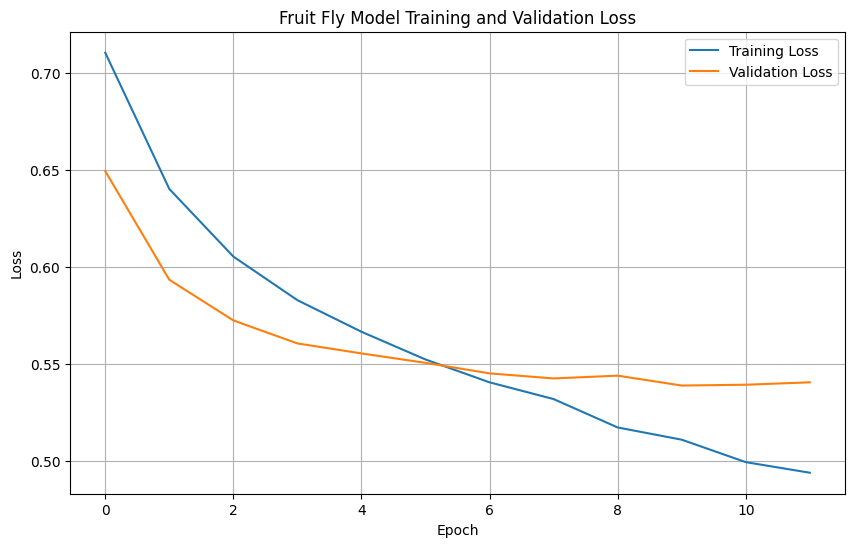

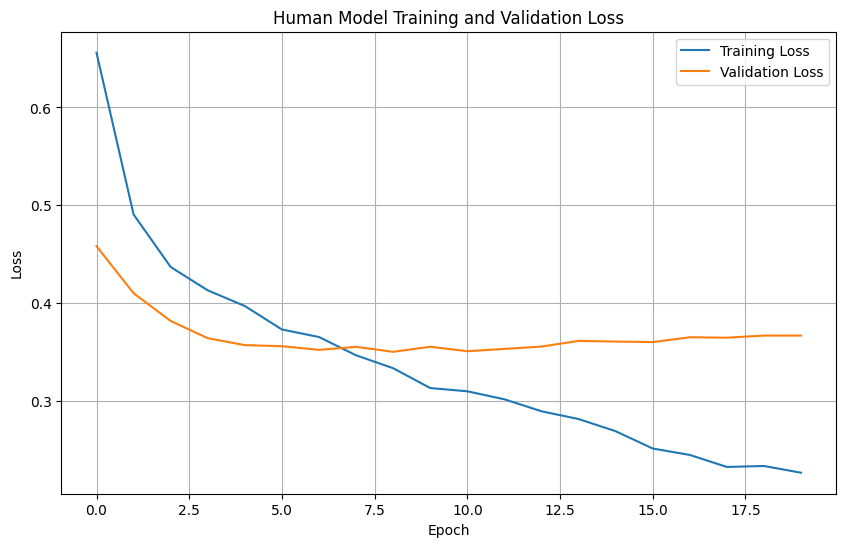

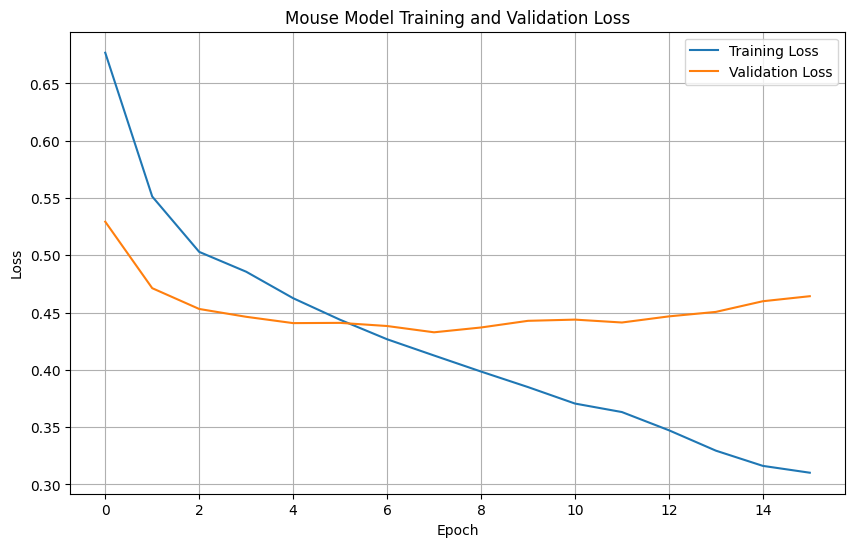

In [25]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

# Fruit Fly
X_train_ff, X_test_ff, y_train_ff, y_test_ff = train_test_split(
    X_fruit_fly, y_fruit_fly,
    test_size=0.15,
    random_state=42,
    stratify=y_fruit_fly
)

# Human
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_human, y_human,
    test_size=0.15,
    random_state=42,
    stratify=y_human
)

# Mouse
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_mouse, y_mouse,
    test_size=0.15,
    random_state=42,
    stratify=y_mouse
)

print(f"Fruit Fly: {len(X_train_ff)} training, {len(X_test_ff)} testing samples")
print(f"Human:     {len(X_train_h)} training, {len(X_test_h)} testing samples")
print(f"Mouse:     {len(X_train_m)} training, {len(X_test_m)} testing samples")


print("Fruit Fly:")
results_ff = train_and_evaluate_species_model(
    X_train_ff, y_train_ff, X_test_ff, y_test_ff, "Fruit Fly"
)

print("Human:")
results_h = train_and_evaluate_species_model(
    X_train_h, y_train_h, X_test_h, y_test_h, "Human"
)

print("Mouse:")
results_m = train_and_evaluate_species_model(
    X_train_m, y_train_m, X_test_m, y_test_m, "Mouse"
)


# Use classification_report for each species
print(f" FRUIT FLY:")
print(classification_report(y_test_ff, results_ff['predictions'], labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))

print(f"\n HUMAN:")
print(classification_report(y_test_h, results_h['predictions'], labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))

print(f"\n MOUSE:")
print(classification_report(y_test_m, results_m['predictions'], labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))

# Plot training and validation loss
def plot_loss(history, species_name):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{species_name} Model Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(results_ff['history'], "Fruit Fly")
plot_loss(results_h['history'], "Human")
plot_loss(results_m['history'], "Mouse")

In [26]:

data_dir_independent = "/kaggle/input/tri-ori/Tri-Ori/independent"
files_independent_ff = ["Ind-Bg3_F_F.txt", "Ind-KC_F_F.txt", "Ind-S2_F_F.txt"]
files_independent_h = ["Ind-K562_Human.txt", "Ind-MCF7_Human.txt"]
files_independent_m = ["Ind-ES_Mouse.txt", "Ind-P19_Mouse.txt", "Ind-MEF_Mouse.txt"]

df_independent_ff = load_fasta_data(data_dir_independent, files_independent_ff)
df_independent_h = load_fasta_data(data_dir_independent, files_independent_h)
df_independent_m = load_fasta_data(data_dir_independent, files_independent_m)

# Calculate k-mer counts and frequencies for independent datasets
df_independent_ff_kmer = pd.DataFrame({
    'label': df_independent_ff['label'],
    'kmer_counts': df_independent_ff['seq'].apply(lambda seq: count_kmers(seq, k_size))
})
df_independent_ff_kmerVec = pd.DataFrame({
    'label': df_independent_ff_kmer['label'],
    'kmer_frequency_vector': df_independent_ff_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

df_independent_h_kmer = pd.DataFrame({
    'label': df_independent_h['label'],
    'kmer_counts': df_independent_h['seq'].apply(lambda seq: count_kmers(seq, k_size))
})
df_independent_h_kmerVec = pd.DataFrame({
    'label': df_independent_h_kmer['label'],
    'kmer_frequency_vector': df_independent_h_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

df_independent_m_kmer = pd.DataFrame({
    'label': df_independent_m['label'],
    'kmer_counts': df_independent_m['seq'].apply(lambda seq: count_kmers(seq, k_size))
})
df_independent_m_kmerVec = pd.DataFrame({
    'label': df_independent_m_kmer['label'],
    'kmer_frequency_vector': df_independent_m_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

# Prepare feature matrices for independent datasets
X_independent_ff, _ = prepare_feature_matrix(df_independent_ff_kmerVec)
y_independent_ff = df_independent_ff_kmerVec['label'].values

X_independent_h, _ = prepare_feature_matrix(df_independent_h_kmerVec)
y_independent_h = df_independent_h_kmerVec['label'].values

X_independent_m, _ = prepare_feature_matrix(df_independent_m_kmerVec)
y_independent_m = df_independent_m_kmerVec['label'].values

# Evaluate models on independent datasets
def evaluate_model_on_independent_data(model_results, X_independent, y_independent, trained_species, independent_species):
    print(f"\n{'='*60}")
    print(f"EVALUATING {trained_species.upper()} MODEL ON {independent_species.upper()} INDEPENDENT DATA")
    print(f"{'='*60}")

    scaler = model_results['scaler']
    model = model_results['model']

    X_independent_scaled = scaler.transform(X_independent)

    y_pred_proba = model.predict(X_independent_scaled)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    print(classification_report(y_independent, y_pred, labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))


# Fruit Fly model on independent datasets
evaluate_model_on_independent_data(results_ff, X_independent_ff, y_independent_ff, "Fruit Fly", "Fruit Fly")
evaluate_model_on_independent_data(results_ff, X_independent_h, y_independent_h, "Fruit Fly", "Human")
evaluate_model_on_independent_data(results_ff, X_independent_m, y_independent_m, "Fruit Fly", "Mouse")

# Human model on independent datasets
evaluate_model_on_independent_data(results_h, X_independent_h, y_independent_h, "Human", "Human")
evaluate_model_on_independent_data(results_h, X_independent_ff, y_independent_ff, "Human", "Fruit Fly")
evaluate_model_on_independent_data(results_h, X_independent_m, y_independent_m, "Human", "Mouse")

# Mouse model on independent datasets
evaluate_model_on_independent_data(results_m, X_independent_m, y_independent_m, "Mouse", "Mouse")
evaluate_model_on_independent_data(results_m, X_independent_ff, y_independent_ff, "Mouse", "Fruit Fly")
evaluate_model_on_independent_data(results_m, X_independent_h, y_independent_h, "Mouse", "Human")

Shortest sequence length in original dataset : 300
Longest  sequence length in original dataset : 300

Total sequences : 16,000
Class balance   : Counter({1: 8000, 0: 8000})

Break-down per file:
  Ind-Bg3_F_F.txt  Pos=2000  Neg=2000
  Ind-KC_F_F.txt  Pos=3000  Neg=3000
  Ind-S2_F_F.txt  Pos=3000  Neg=3000

DataFrame preview:


,seq,label
9245,TGCGTGTTCCTTACCCGAATTACTTTTTGCAGTGAATCGTTTGGCG...,0
11538,ACATGCATATATACATACATACATACATACATGGGGTGTTTGTTTA...,1
9860,AGGGTCTTGTTTTTTGTTTTGTTTTTTCAATTTTCCAGCTCTAATG...,0
1780,GGCAGTATCCCAAATTGTCAACCTCGTTGACATTCCAGAGGAAGAG...,1
3974,TCCTCAATTTGGTTATTTACTTGTGCTTCGTAGGCAAAGGGAGTAT...,0





Shortest sequence length in original dataset : 300
Longest  sequence length in original dataset : 300

Total sequences : 4,000
Class balance   : Counter({1: 2000, 0: 2000})

Break-down per file:
  Ind-K562_Human.txt  Pos=1000  Neg=1000
  Ind-MCF7_Human.txt  Pos=1000  Neg=1000

DataFrame preview:


,seq,label
882,TTTAGGAGATAAAATAGAAGGTGGCGGCAAGGAAGGGAGAGGACAG...,1
270,CTGGGGCCCCTCGTCCCCCGAAGAGTCCTTCCGATCCGGTACCGGT...,1
1065,AGGTCTCTCAAGGGGCCTGGGCGACGATGGAGACCCATCTCCCTCT...,0
3027,AATGGCCACGTGAGACAGAGGCAGAGGCAGAGGCAGAGATTGGACC...,0
3173,CAATCTCCTAAGGCCAACATGTTTTTTATTCTAAAAAACATTTCCC...,0





Shortest sequence length in original dataset : 300
Longest  sequence length in original dataset : 300

Total sequences : 6,000
Class balance   : Counter({1: 3000, 0: 3000})

Break-down per file:
  Ind-ES_Mouse.txt  Pos=1000  Neg=1000
  Ind-P19_Mouse.txt  Pos=1000  Neg=1000
  Ind-MEF_Mouse.txt  Pos=1000  Neg=1000

DataFrame preview:


,seq,label
3954,CCTCCTGAAGAACAGCCTGTGTTCTTAACTGCTGAGCCATCTCACC...,0
1480,GCTGGGATTAAAAGTGTAGTCCACCACACCCAGTCTATATTGGGTA...,0
1407,AGGCACCAGGCACACACATGCTACACAGACTCGCACACAGTCAGAA...,0
4778,CTGGAGACTTCCACCCAGAGAAGCTCCACAGGGGAGCTCCACACGG...,1
2510,CCCCCCAACCACCTCTTGCCTCCGCCGGGGAGCAGCAGCCGGGGAG...,1






EVALUATING FRUIT FLY MODEL ON FRUIT FLY INDEPENDENT DATA
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                     precision    recall  f1-score   support

    Positive (oriC)       0.76      0.73      0.74      8000
Negative (Non-oriC)       0.74      0.77      0.75      8000

           accuracy                           0.75     16000
          macro avg       0.75      0.75      0.75     16000
       weighted avg       0.75      0.75      0.75     16000


EVALUATING FRUIT FLY MODEL ON HUMAN INDEPENDENT DATA
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                     precision    recall  f1-score   support

    Positive (oriC)       0.46      0.61      0.52      2000
Negative (Non-oriC)       0.42      0.28      0.34      2000

           accuracy                           0.45      4000
          macro avg       0.44      0.44      0.43      4000
       weighted avg       0.44      0.45      0.43      4000


EVALUATING FRUIT FLY MODEL ON MOUSE INDEPENDENT DATA
188/188 ━━━

# Training Combining all Data

In [27]:
import pandas as pd
from collections import Counter

# Combine all species dataframes
df_combined = pd.concat([df_fruit_fly, df_human, df_mouse], ignore_index=True)

print("Combined DataFrame preview:")
display(df_combined.sample(5))
print(f"\nTotal sequences in combined dataset: {len(df_combined):,}")
print(f"Class balance in combined dataset: {Counter(df_combined.label)}")

# Calculate k-mer counts and frequencies for the combined dataset
df_combined_kmer = pd.DataFrame({
    'label': df_combined['label'],
    'kmer_counts': df_combined['seq'].apply(lambda seq: count_kmers(seq, k_size))
})

combined_species_vec = pd.DataFrame({
    'label': df_combined_kmer['label'],
    'kmer_frequency_vector': df_combined_kmer['kmer_counts'].apply(calculate_kmer_frequencies)
})

# Augment the combined dataset
df_combined_aug = augment_dataframe(combined_species_vec, n_augments=1)

print(f"\nAugmented Combined DataFrame preview:")
display(df_combined_aug.sample(5))
print(f"\nTotal sequences in augmented combined dataset: {len(df_combined_aug):,}")
print(f"Class balance in augmented combined dataset: {Counter(df_combined_aug.label)}")

Combined DataFrame preview:


,seq,label
12194,TTCAATAGATAACAGCTGGGTTGTATGATTTTAAAGGTAGGAACTC...,1
15003,GGACTGACTACTTAATACAATTAACATGAACCAACTCTATTAAAAC...,0
18136,ATGAGATTTCGACGCATTAAGTCCTGGGTGTTGCTGGATACTGTAT...,0
5896,ACAAAAATGTGTATGGACTATAAAAAAAAAATGCCCACATATACAT...,1
17603,ACATTTATCTAGATGCATTTGAACAAGTGGGTATGGTTTTGAATAA...,0



Total sequences in combined dataset: 33,053
Class balance in combined dataset: Counter({1: 16537, 0: 16516})

Augmented Combined DataFrame preview:


,label,kmer_frequency_vector
53358,0,"{'GGGCC': 0.00837684213323016, 'GGCCC': 0.0008..."
65200,0,"{'GCAAT': 0.0, 'CAATC': 0.004188593054957682, ..."
11889,1,"{'TTGTA': 0.0033783783783783786, 'TGTAT': 0.00..."
46910,1,"{'GAGAT': 0.0, 'AGATT': 0.01835438401379884, '..."
25673,1,"{'AGGTT': 0.0033783783783783786, 'GGTTG': 0.00..."



Total sequences in augmented combined dataset: 66,106
Class balance in augmented combined dataset: Counter({1: 33074, 0: 33032})


# Train and Test on Combined dataset


 DATA SUMMARY:
Combined Augmented: 66106 samples, 1024 k-mer features

 CLASS DISTRIBUTION:
Combined Augmented - Positive: 33074, Negative: 33032

Combined Augmented: 56190 training, 9916 testing samples

TRAINING MODEL FOR COMBINED
Training set: 56190 samples, 1024 features
Test set: 9916 samples


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.5525 - loss: 0.7717 - val_accuracy: 0.6327 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 2/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6510 - loss: 0.6255 - val_accuracy: 0.6981 - val_loss: 0.5793 - learning_rate: 0.0010
Epoch 3/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6891 - loss: 0.6010 - val_accuracy: 0.7122 - val_loss: 0.5647 - learning_rate: 0.0010
Epoch 4/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7096 - loss: 0.5801 - val_accuracy: 0.7232 - val_loss: 0.5539 - learning_rate: 0.0010
Epoch 5/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7126 - loss: 0.5737 - val_accuracy: 0.7186 - val_loss: 0.5482 - learning_rate: 0.0010
Epoch 6/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7173 - loss: 0.5673 - val_accuracy: 0.7263 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 7/100
1493/1493 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.

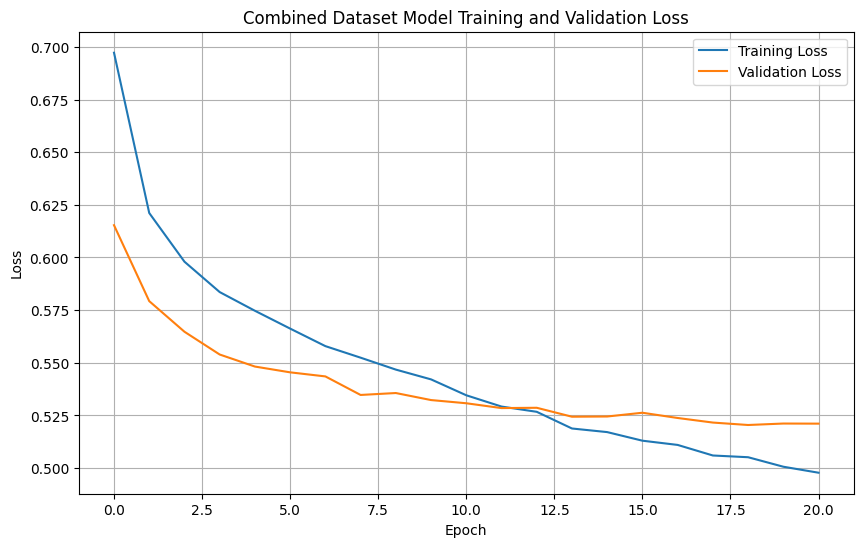

In [28]:
# Prepare feature matrix and labels for the combined augmented dataset
X_combined, kmers_combined = prepare_feature_matrix(df_combined_aug)
y_combined = df_combined_aug['label'].values

print(f"\n DATA SUMMARY:")
print(f"Combined Augmented: {X_combined.shape[0]} samples, {X_combined.shape[1]} k-mer features")
print(f"\n CLASS DISTRIBUTION:")
print(f"Combined Augmented - Positive: {sum(y_combined)}, Negative: {len(y_combined)-sum(y_combined)}")

# Split the combined data into training and testing sets
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
    X_combined, y_combined,
    test_size=0.15,
    random_state=42,
    stratify=y_combined
)

print(f"\nCombined Augmented: {len(X_train_combined)} training, {len(X_test_combined)} testing samples")


# Train and evaluate the model on the combined dataset
results_combined = train_and_evaluate_species_model(
    X_train_combined, y_train_combined, X_test_combined, y_test_combined, "Combined"
)

# Print classification report for the combined model
print(f"\n COMBINED DATASET:")
print(classification_report(y_test_combined, results_combined['predictions'], labels=[1, 0], target_names=['Positive (oriC)', 'Negative (Non-oriC)']))

# Plot training and validation loss for the combined model
plot_loss(results_combined['history'], "Combined Dataset")

# Testing Independent Data on this Combined Model

In [29]:

evaluate_model_on_independent_data(results_combined, X_independent_ff, y_independent_ff, "Combined", "Fruit Fly (Independent)")
evaluate_model_on_independent_data(results_combined, X_independent_h, y_independent_h, "Combined", "Human (Independent)")
evaluate_model_on_independent_data(results_combined, X_independent_m, y_independent_m, "Combined", "Mouse (Independent)")


EVALUATING COMBINED MODEL ON FRUIT FLY (INDEPENDENT) INDEPENDENT DATA
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
                     precision    recall  f1-score   support

    Positive (oriC)       0.76      0.68      0.72      8000
Negative (Non-oriC)       0.71      0.79      0.74      8000

           accuracy                           0.73     16000
          macro avg       0.73      0.73      0.73     16000
       weighted avg       0.73      0.73      0.73     16000


EVALUATING COMBINED MODEL ON HUMAN (INDEPENDENT) INDEPENDENT DATA
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
                     precision    recall  f1-score   support

    Positive (oriC)       0.74      0.84      0.79      2000
Negative (Non-oriC)       0.82      0.70      0.75      2000

           accuracy                           0.77      4000
          macro avg       0.78      0.77      0.77      4000
       weighted avg       0.78      0.77      0.77      4000


EVALUATING COMBINED MODEL ON MOUSE (INDEP